In [1]:
import tensorflow as tf

def setup_gpu_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # 打印异常信息
            print(e)

# 在程序的开始调用这个函数
setup_gpu_memory_growth()

# 以下是你的其他TensorFlow代码


In [2]:
import os

# 设置环境变量
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# 现在可以运行你的TensorFlow代码了


In [3]:
import tensorflow as tf

In [4]:
from keras.optimizers import Adam

In [5]:
import dlmodels

In [6]:
import tensorflow.keras.models as models

In [7]:
import tensorflow.keras.optimizers as optimizers

In [8]:
import tensorflow.keras.utils as kutils

In [9]:
import sklearn.ensemble

In [10]:
import sklearn.metrics

In [11]:
import rasterio

In [12]:
import matplotlib.pyplot as plt

In [13]:
import numpy as np

In [14]:
import pandas

In [15]:
import os

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
SEED = 42
np.random.seed(SEED)

In [18]:
import keras
from keras import losses
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten


In [19]:
from fusion import create_model

In [20]:
#import fusion  ######改成py！！！！

In [21]:
#####optical

In [22]:
import os

# 定义数据集目录
BASE_DIR = "/home/jovyan/private/thesis_data/code/final_code/dataset"
# 假设您有三个不同的目录，分别存储不同类型的图像
S1_IMAGE_DIR = os.path.join(BASE_DIR, "sentinel1_images")
S2_10_IMAGE_DIR = os.path.join(BASE_DIR, "sentinel2_10_images")
S2_20_IMAGE_DIR = os.path.join(BASE_DIR, "sentinel2_20_images")
GEDI_IMAGE_DIR = os.path.join(BASE_DIR, "gedi_4")
LABEL_250_DIR = os.path.join(BASE_DIR, "LABEL_250_DIR")
LABEL_100_DIR = os.path.join(BASE_DIR, "LABEL_100_DIR")


# 定义常量

BATCH_SIZE = 3
EPOCHS = 1000
STEPS = 500

# 定义测试和验证图像的文件名
# 假设每种类型的图像都有相同的命名方式
TRAIN_IMAGES = ["2.tif", "7.tif", "4.tif", "5.tif", "9.tif", "12.tif", "17.tif", "11.tif"]
VAL_IMAGES = ["6.tif", "16.tif", "10.tif","15.tif"]
TEST_IMAGES = ["8.tif","14.tif", "3.tif"]



In [23]:
patch_sizes = {"s1": (224, 224), "s2_10": (224, 224),"s2_20":(112,112), "gedi": (28, 28), "LABEL_250_DIR": (9, 9), "LABEL_100_DIR": (23, 23)}
bands_count = {"s1": 6, "s2_10": 4,"s2_20":6,"gedi":4 }
label_dirs = ['LABEL_250_DIR', 'LABEL_100_DIR']

In [24]:
#####read multiband image

In [25]:
def read_and_preprocess_image(image_path, normalise_percentiles=(0.5, 99), is_complex=False):
    with rasterio.open(image_path) as image_file:
        image_arr = image_file.read()  # 以[通道, 高度, 宽度]格式读取所有波段
       
        image_arr[image_arr == image_file.nodata] = np.nan
                # 如果提供了模板，则应用模板
        # if template is not None:
        #     image_arr = apply_template(image_arr, template)
        
        if normalise_percentiles:
            for band in range(image_arr.shape[0]):
                band_arr = image_arr[band, :, :]
                min_value = np.nanpercentile(band_arr, normalise_percentiles[0])
                max_value = np.nanpercentile(band_arr, normalise_percentiles[1])
                if max_value - min_value > np.finfo(float).eps:
                    image_arr[band, :, :] = (band_arr - min_value) / (max_value - min_value)
                else:
                    image_arr[band, :, :] = np.zeros_like(band_arr)
                    
                    
        if is_complex:
            # 对于复数数据的特殊处理
            real_channel_1 = np.expand_dims(image_arr[0], axis=0)  # 第一个通道，扩展维度以便堆叠
            imag_channel_1 = np.zeros_like(real_channel_1)  # 第一个通道的虚部，使用零填充
            
            complex_real = np.expand_dims(image_arr[1], axis=0)  # 第二个通道作为复数的实部
            complex_imag = np.expand_dims(image_arr[2], axis=0)  # 第三个通道作为复数的虚部
            
            real_channel_4 = np.expand_dims(image_arr[3], axis=0)  # 第四个通道
            imag_channel_4 = np.zeros_like(real_channel_4)  # 第四个通道的虚部，使用零填充
            
            # 沿通道轴堆叠以创建6个通道
            image_arr = np.concatenate([real_channel_1, imag_channel_1, complex_real, complex_imag, real_channel_4, imag_channel_4], axis=0)

        # 在返回之前将 NaN 和 Inf 转换为 0
        # 此处 posinf 和 neginf 参数可用于指定用于替换正、负无穷的值；默认行为是用最大或最小的浮点数替换
        image_arr = np.nan_to_num(image_arr, nan=0.0, posinf=None, neginf=None)

    return image_arr.transpose(1, 2, 0)  # 重新排序维度为高度 x 宽度 x 通道


In [26]:

def read_single_band_image(image_path, normalise_percentiles=(0, 100)):
    with rasterio.open(image_path) as image_file:
        image_arr = image_file.read(1)  # Reads the first band
        
        # Checks and replaces nodata values with np.nan
        if image_file.nodata is not None:
            image_arr[image_arr == image_file.nodata] = np.nan
        
        # Applies normalization if needed
        if normalise_percentiles:
            min_value = np.nanpercentile(image_arr, normalise_percentiles[0])
            max_value = np.nanpercentile(image_arr, normalise_percentiles[1])
            if max_value - min_value > np.finfo(float).eps:
                image_arr = (image_arr - min_value) / (max_value - min_value)
            else:
                image_arr = np.zeros_like(image_arr)
        
        # Converts np.nan to 0.0
        single_band_image = np.nan_to_num(image_arr, nan=0.0)
    
    # Adds a channel dimension and returns
    return np.expand_dims(single_band_image, axis=-1)


In [27]:
#反归一化：在某些情况下，特别是回归问题中，你可能需要将预测结果“反归一化”回原始的数值范围，以便结果更易于理解和使用。这要求保存归一化过程中使用的参数（如最小值和最大值），以便在预测后进行逆操作。

In [28]:
#####别忘了patch

In [29]:
def pad_image_to_patch_size(image, patch_size):
    height, width, depth = image.shape
    patch_height, patch_width = patch_size  # 解包元组，分别获取补丁的高度和宽度

    # 计算目标高度和宽度
    target_height = patch_height * (height // patch_height + (1 if height % patch_height != 0 else 0))
    target_width = patch_width * (width // patch_width + (1 if width % patch_width != 0 else 0))

    # 计算填充量
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2

    # 创建填充后的图像
    padded = np.zeros((target_height, target_width, depth), dtype=image.dtype)
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image

    return padded, (pad_height, pad_width)


In [30]:
class TrainSequence(kutils.Sequence):
    def __init__(self, filenames, batch_size, patch_sizes, bands_count, len, label_dirs):
        self.filenames = filenames
        self.batch_size = batch_size
        self.patch_sizes = patch_sizes  # 字典，包含每种图像和标签的补丁大小
        self.bands_count = bands_count  # 字典，包含每种图像类型的波段数
        self.len = len
        self.label_dirs = ['LABEL_250_DIR', 'LABEL_100_DIR']  # 列表，包含标签的目录
        self.read_dataset()

    def read_dataset(self):
        self.data = []
        for filename in self.filenames:
            # 读取和处理图像
            s1_image_path = os.path.join(S1_IMAGE_DIR, filename)
            s2_10_image_path = os.path.join(S2_10_IMAGE_DIR, filename)
            s2_20_image_path = os.path.join(S2_20_IMAGE_DIR, filename)
            gedi_image_path = os.path.join(GEDI_IMAGE_DIR, filename)
            
            #s1_image = read_and_preprocess_image(s1_image_path, normalise=True)
            s1_image = read_and_preprocess_image(s1_image_path, is_complex=True)

            
            s2_10_image = read_and_preprocess_image(s2_10_image_path)
            s2_20_image = read_and_preprocess_image(s2_20_image_path)
            gedi_image = read_and_preprocess_image(gedi_image_path)
            
            # Pad each image according to its patch size
            s1_image, _ = pad_image_to_patch_size(s1_image, self.patch_sizes['s1'])
            s2_10_image, _ = pad_image_to_patch_size(s2_10_image, self.patch_sizes['s2_10'])
            s2_20_image, _ = pad_image_to_patch_size(s2_20_image, self.patch_sizes['s2_20'])
            gedi_image, _ = pad_image_to_patch_size(gedi_image, self.patch_sizes['gedi'])


            images = {'s1': s1_image, 's2_10': s2_10_image, 's2_20':s2_20_image, 'gedi': gedi_image}

            # 读取和处理标签
            labels = []
            for label_type in self.label_dirs:
                label_path = os.path.join(BASE_DIR, label_type, filename)
                label = read_single_band_image(label_path)
                # 使用 label_type 作为键来获取对应的补丁大小
                label, _ = pad_image_to_patch_size(label, self.patch_sizes[label_type])
                labels.append(label)


            self.data.append((images, labels))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        batch_x = {key: np.empty((self.batch_size, *self.patch_sizes[key], self.bands_count[key])) for key in ['s1', 's2_10', 's2_20', 'gedi']}
        batch_y = [np.empty((self.batch_size, *self.patch_sizes[label_dir], 1)) for label_dir in self.label_dirs]

        for patch_index in range(self.batch_size):
            images, labels = self.sample_image()

            # 基于参考图像（例如s1）计算采样起始点的比例
            ref_image = images['s1']
            y_ratio, x_ratio = self.calculate_sampling_start_point(ref_image, self.patch_sizes['s1'])

            for key, image in images.items():
                patch_size = self.patch_sizes[key]
                batch_x[key][patch_index] = self.sample_patch(image, patch_size, y_ratio, x_ratio)

            for i, label_dir in enumerate(self.label_dirs):
                label = labels[i]
                label_patch_size = self.patch_sizes[label_dir]
                batch_y[i][patch_index] = self.sample_patch(label, label_patch_size, y_ratio, x_ratio)

        return [batch_x[key] for key in batch_x], batch_y

    def sample_image(self):
        # 随机选择一个图像和标签集
        image_index = np.random.choice(len(self.data))
        selected_data = self.data[image_index]
        images = selected_data[0]  # 第一个元素是图像的字典
        labels = selected_data[1]  # 第二个元素是标签的列表
        # 打印选中的image_index
        #print("Selected image index:", image_index)
        return images, labels  # 返回图像字典和标签列表

    def sample_patch(self, image, patch_size, y_ratio, x_ratio):
        # 根据提供的比例和补丁大小采样补丁
        height, width, _ = image.shape
        y_start = int((height - patch_size[0]) * y_ratio)
        x_start = int((width - patch_size[1]) * x_ratio)
        return image[y_start:y_start + patch_size[0], x_start:x_start + patch_size[1], :]

    def calculate_sampling_start_point(self, reference_image, reference_patch_size):
        # 基于参考图像和参考补丁大小计算采样起始点的比例
        height, width, _ = reference_image.shape
        y_ratio = np.random.uniform(0, 1 - reference_patch_size[0] / height)
        x_ratio = np.random.uniform(0, 1 - reference_patch_size[1] / width)
        return y_ratio, x_ratio

In [31]:
train_sequence = TrainSequence(TRAIN_IMAGES, BATCH_SIZE, patch_sizes, bands_count, STEPS, label_dirs)

In [32]:
import numpy as np

def check_nan_or_inf_in_batch(data):
    #"""检查批次数据中是否包含NaN或Inf值。"""
    if isinstance(data, dict):
        # 如果数据是字典类型，则遍历每个键
        for key, value in data.items():
            if np.any(np.isnan(value)) or np.any(np.isinf(value)):
                return True
    elif isinstance(data, list):
        # 如果数据是列表
        for item in data:
            if isinstance(item, np.ndarray):
                if np.any(np.isnan(item)) or np.any(np.isinf(item)):
                    return True
            else:
                # 对于嵌套的列表或其它结构，需要进一步检查或适当处理
                pass
    elif isinstance(data, np.ndarray):
        # 对于直接的NumPy数组
        if np.any(np.isnan(data)) or np.any(np.isinf(data)):
            return True
    return False


# 假设 train_sequence 是你的 TrainSequence 实例
for idx in range(len(train_sequence)):
    batch_x, batch_y = train_sequence[idx]  # 获取批次数据
    
    # 检查特征数据和标签数据中是否有 NaN 或 Inf 值
    if check_nan_or_inf_in_batch(batch_x):
        print(f"NaN or Inf detected in features of batch {idx}")
    if check_nan_or_inf_in_batch(batch_y):
        print(f"NaN or Inf detected in labels of batch {idx}")


In [33]:
x, y = train_sequence[0] 

In [34]:
# 对 x 进行检查，这里假设 x 是一个列表或数组的列表
for i, item in enumerate(x):
    if np.isnan(item).any():
        print(f"NaN value detected in x at index {i}")

# 对 y 进行检查，这里假设 y 是一个列表或数组的列表
for i, item in enumerate(y):
    if np.isnan(item).any():
        print(f"NaN value detected in y at index {i}")


In [35]:
# 打印x的类型和内容示例
print(type(y))


<class 'list'>


In [36]:
# import matplotlib.pyplot as plt

# # x 是一个列表，y 是一个标签列表的列表
# # 假设x中的顺序与bands_count中的键顺序一致

# # 计算绘图的总行数：所有输入的波段数 + 所有输出的数量
# input_band_count = sum(bands_count.values())
# output_label_count = sum(len(labels) for labels in y)
# nrows = input_band_count + output_label_count
# ncols = 1  # 因为我们只查看第一个批次的数据

# fig, axes = plt.subplots(nrows, ncols, figsize=(5, nrows * 2), squeeze=False)

# current_row = 0
# # 可视化每个输入图像的所有波段
# for input_index, (input_key, band_count) in enumerate(bands_count.items()):
#     for band_index in range(band_count):
#         ax = axes[current_row, 0]
#         ax.imshow(x[input_index][0, :, :, band_index], cmap='gray')
#         ax.axis('off')
#         ax.set_title(f'Input: {input_key}, Band: {band_index + 1}')
#         current_row += 1

# # 可视化每个输出标签
# for label_set_index, label_set in enumerate(y):  # y 是标签列表的列表
#     for label_index, label_data in enumerate(label_set):
#         ax = axes[current_row, 0]
#         ax.imshow(label_data[:, :, 0], cmap='viridis')  # 这里做了修正
#         ax.axis('off')
#         ax.set_title(f'Output Label Set: {label_set_index + 1}, Label: {label_index + 1}')
#         current_row += 1

# plt.tight_layout()
# plt.show()


In [37]:
# import numpy as np
# import os
# import keras.utils as kutils

# class ValSequence(kutils.Sequence):
#     def __init__(self, filenames, batch_size, patch_sizes, bands_count, label_dirs):
#         self.filenames = filenames
#         self.batch_size = batch_size
#         self.patch_sizes = patch_sizes
#         self.bands_count = bands_count
#         self.label_dirs = label_dirs
#         self.read_dataset()
#         self.reset()

#     def read_dataset(self):
#         self.data = []
#         min_patches_count = None

#         for filename in self.filenames:
#             # 读取和处理图像
#             s1_image_path = os.path.join(S1_IMAGE_DIR, filename)
#             s2_10_image_path = os.path.join(S2_10_IMAGE_DIR, filename)
#             s2_20_image_path = os.path.join(S2_20_IMAGE_DIR, filename)
#             gedi_image_path = os.path.join(GEDI_IMAGE_DIR, filename)
            
#             #s1_image = read_and_preprocess_image(s1_image_path, normalise=True)
#             s1_image = read_and_preprocess_image(s1_image_path, is_complex=True)

#             # 然后处理其他图像，并使用S1图像作为模板
#             s2_10_image = read_and_preprocess_image(s2_10_image_path)
#             s2_20_image = read_and_preprocess_image(s2_20_image_path)
#             gedi_image = read_and_preprocess_image(gedi_image_path)
            
#             images = {'s1': s1_image, 's2_10': s2_10_image, 's2_20':s2_20_image, 'gedi': gedi_image}

#             labels = {}
#             for label_type in self.label_dirs:
#                 label_path = os.path.join(BASE_DIR, label_type, filename)
#                 label = read_single_band_image(label_path)
#                 labels[label_type] = label


#             # Pad images and labels to their respective patch sizes
#             for key in images:
#                 images[key], _ = pad_image_to_patch_size(images[key], self.patch_sizes[key])
#             for key in labels:
#                 labels[key], _ = pad_image_to_patch_size(labels[key], self.patch_sizes[key])

#             # Calculate patches count for each image and label, then update min_patches_count
#             all_sizes = {**images, **labels}  # Combine images and labels for unified processing
#             for key, item in all_sizes.items():
#                 patch_size = self.patch_sizes[key]
#                 patches_count = (item.shape[0] // patch_size[0]) * (item.shape[1] // patch_size[1])
#                 if min_patches_count is None or patches_count < min_patches_count:
#                     min_patches_count = patches_count

#             self.data.append((images, labels))

#         self.len = min_patches_count * len(self.filenames) // self.batch_size

#     def __len__(self):
#         return self.len
    
    
#     def __getitem__(self, idx):
#         batch_x = {key: np.empty((self.batch_size, *self.patch_sizes[key], self.bands_count[key])) for key in ['s1', 's2_10', 's2_20', 'gedi']}
#         batch_y = {key: np.empty((self.batch_size, *self.patch_sizes[key], 1)) for key in self.label_dirs}

#         # 为整个batch计算一个统一的采样起始点
#         images, labels = self.data[idx % len(self.data)]
#         ref_image = list(images.values())[0]  # 使用第一个图像作为参考
#         patch_size = list(self.patch_sizes.values())[0]  # 使用第一个patch size作为参考
#         height, width, _ = ref_image.shape
#         max_y = height - patch_size[0]
#         max_x = width - patch_size[1]
#         y = np.random.randint(0, max_y) if max_y > 0 else 0
#         x = np.random.randint(0, max_x) if max_x > 0 else 0

#         for i in range(self.batch_size):
#             for key, image in images.items():
#                 batch_x[key][i, ...] = image[y:y + self.patch_sizes[key][0], x:x + self.patch_sizes[key][1], :]
#             for key, label in labels.items():
#                 batch_y[key][i, ...] = label[y:y + self.patch_sizes[key][0], x:x + self.patch_sizes[key][1], :]

#         return [batch_x[key] for key in batch_x], [batch_y[key] for key in batch_y]


#     def sample_image(self):
#         image_index = np.random.choice(len(self.data))
#         return self.data[image_index]

#     def reset(self):
#         # Resets the sequence to the start
#         self.image_index = 0


In [38]:
val_sequence =TrainSequence(VAL_IMAGES,BATCH_SIZE, patch_sizes, bands_count, STEPS, label_dirs)

In [39]:
# 假设 train_sequence 是你的 TrainSequence 实例
for idx in range(len(val_sequence)):
    batch_x, batch_y = val_sequence[idx]  # 获取批次数据
    
    # 检查特征数据和标签数据中是否有 NaN 或 Inf 值
    if check_nan_or_inf_in_batch(batch_x):
        print(f"NaN or Inf detected in features of batch {idx}")
    if check_nan_or_inf_in_batch(batch_y):
        print(f"NaN or Inf detected in labels of batch {idx}")

In [40]:
# import matplotlib.pyplot as plt

# x,y=val_sequence[1]
# # x 是一个列表，y 是一个标签列表的列表
# # 假设x中的顺序与bands_count中的键顺序一致

# # 计算绘图的总行数：所有输入的波段数 + 所有输出的数量
# input_band_count = sum(bands_count.values())
# output_label_count = sum(len(labels) for labels in y)
# nrows = input_band_count + output_label_count
# ncols = 1  # 因为我们只查看第一个批次的数据

# fig, axes = plt.subplots(nrows, ncols, figsize=(5, nrows * 2), squeeze=False)

# current_row = 0
# # 可视化每个输入图像的所有波段
# for input_index, (input_key, band_count) in enumerate(bands_count.items()):
#     for band_index in range(band_count):
#         ax = axes[current_row, 0]
#         ax.imshow(x[input_index][0, :, :, band_index], cmap='gray')
#         ax.axis('off')
#         ax.set_title(f'Input: {input_key}, Band: {band_index + 1}')
#         current_row += 1

# # 可视化每个输出标签
# for label_set_index, label_set in enumerate(y):  # y 是标签列表的列表
#     for label_index, label_data in enumerate(label_set):
#         ax = axes[current_row, 0]
#         ax.imshow(label_data[:, :, 0], cmap='viridis')  # 这里做了修正
#         ax.axis('off')
#         ax.set_title(f'Output Label Set: {label_set_index + 1}, Label: {label_index + 1}')
#         current_row += 1

# plt.tight_layout()
# plt.show()


In [41]:
#val_sequence = ValSequence(VAL_IMAGES, BATCH_SIZE, patch_sizes, bands_count, label_dirs)

In [42]:
# 设置输入尺寸
input_shape_s1 = 224,224,6  # Sentinel-1 输入尺寸
input_shape_s10 = 224,224,4  # Sentinel-2 输入尺寸
input_shape_s20 = 112,112,6  # Sentinel-2 输入尺寸
input_shape_gedi = 28, 28, 4  # GEDI 输入尺寸

In [43]:
model = create_model(input_shape_s1, input_shape_s10, input_shape_s20, input_shape_gedi)

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 6  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 4  0           []                               
                                )]                                                                
                                                                                                  
 c_conv2d (CConv2D)             (None, 224, 224, 12  3584        ['input_1[0][0]']                
                                8)                                                            

In [45]:
import tensorflow as tf
from tensorflow.keras import backend as K

# 自定义损失函数
def custom_mse(y_true, y_pred):
    eps = K.epsilon()  # 获取一个小常数
    return K.mean(K.square(y_pred - y_true) + eps, axis=-1)  # 将小常数加到损失计算中

# 定义损失函数字典，使用自定义损失函数
losses1 = {
    'output_250': custom_mse,  # 使用自定义的损失函数
    'output_100': custom_mse   # 同上
}

# 损失权重保持不变
loss_weights1 = {
    'output_250': 0.4,
    'output_100': 0.6
}


In [46]:
# losses1 = {
#     'output_250': 'mean_squared_error',  # 假设这是正确的层名称
#     'output_100': 'mean_squared_error'   # 确保这里没有多余的空格
# }
# loss_weights1 = {
#     'output_250': 0.7,
#     'output_100': 0.3
# }

In [47]:
from keras import backend as K

In [48]:
# 自定义 R² 指标函数
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [49]:
import numpy as np
from tensorflow.keras.callbacks import Callback

class DetectNaNCallback(Callback):
    def on_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        if any(np.isnan(w).any() for w in weights):
            print(f'NaN detected in weights at batch {batch}')
            self.model.stop_training = True

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        if any(np.isnan(w).any() for w in weights):
            print(f'NaN detected in weights at epoch {epoch}')
            self.model.stop_training = True


In [66]:
optimizer1 = keras.optimizers.Adam(1e-3, clipnorm=1, epsilon=1e-4)
model.compile(optimizer=optimizer1, loss=losses1, loss_weights=loss_weights1, metrics=['mse',r_squared,'mae'])

In [51]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 初始化回调函数
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 监控的值
    factor=0.1,          # 学习率减少的因子
    patience=5,         # 在减少学习率之前，等待几个epoch
    min_lr=0.00001       # 学习率的下限
)


In [52]:
####学习率调整试一下

In [53]:
nan_detect_callback = DetectNaNCallback()


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

# 定义早停规则
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控的指标，常见的有'val_loss'和'val_accuracy'
    min_delta=0.001,  # 表示被监控指标的最小变化量，只有大于这个值时才认为模型有改善
    patience=10,  # 指定在监控指标没有改善的情况下等待的epochs数量
    verbose=1,  # 控制输出，1表示输出早停信息
    mode='min',  # 在监控指标为'val_loss'时，我们希望其最小化，因此设置为'min'。如果监控指标为'val_accuracy'，则设置为'max'
    restore_best_weights=True  # 当早停发生时，是否恢复到最好的模型权重
)



In [67]:
from keras.callbacks import ModelCheckpoint

# 设置ModelCheckpoint回调函数来保存验证损失最小的模型权重
model_checkpoint_callback = ModelCheckpoint(
    filepath='/home/jovyan/private/thesis_data/code/final_code/weight/0409_3_1e-3_best_model_weights.h5',  # 保存文件的路径
    save_weights_only=True,  # True表示只保存模型的权重，False则保存整个模型
    monitor='val_loss',  # 被监控的数据
    mode='min',  # 在'min'模式下，监控数据的减少被认为是改进
    save_best_only=True  # True表示只保存在验证集上性能最好的模型
)


In [56]:
#正则化，resent，加数据

In [57]:
#model.load_weights('model_weights.h5')

In [68]:
history= model.fit(
    train_sequence, 
    epochs=50,
    batch_size=BATCH_SIZE, 
    verbose=1,  
    validation_data=val_sequence,
    callbacks=[nan_detect_callback, model_checkpoint_callback,reduce_lr]
)

Epoch 1/50
500/500 [==============================] - 1652s 2s/step - loss: 0.0377 - output_250_loss: 0.0387 - output_100_loss: 0.0371 - output_250_mse: 0.0387 - output_250_r_squared: -0.4724 - output_250_mae: 0.1502 - output_100_mse: 0.0371 - output_100_r_squared: -0.2253 - output_100_mae: 0.1457 - val_loss: 0.0556 - val_output_250_loss: 0.0567 - val_output_100_loss: 0.0549 - val_output_250_mse: 0.0567 - val_output_250_r_squared: -5.1193 - val_output_250_mae: 0.1909 - val_output_100_mse: 0.0549 - val_output_100_r_squared: -5.2342 - val_output_100_mae: 0.1909 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 990s 2s/step - loss: 0.0381 - output_250_loss: 0.0392 - output_100_loss: 0.0374 - output_250_mse: 0.0392 - output_250_r_squared: -0.3553 - output_250_mae: 0.1515 - output_100_mse: 0.0374 - output_100_r_squared: -0.1973 - output_100_mae: 0.1466 - val_loss: 0.0701 - val_output_250_loss: 0.0734 - val_output_100_loss: 0.0679 - val_output_250_mse: 0.0734 - val_output_25

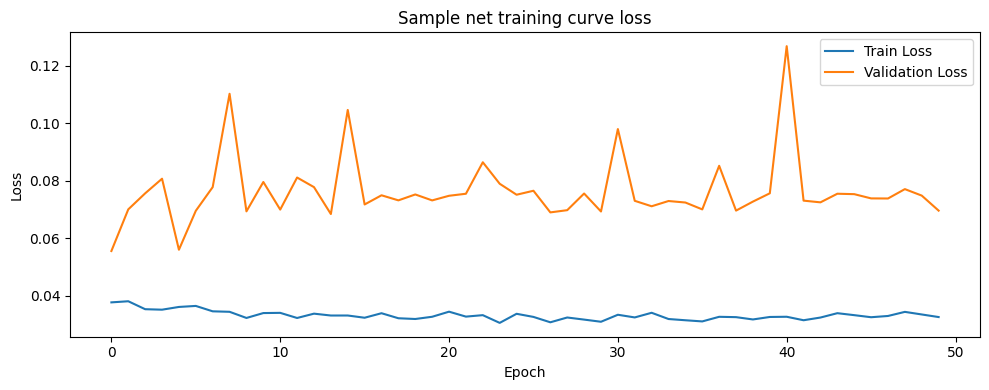

In [69]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

# 绘制损失曲线
axs.set_title("Sample net training curve loss")
axs.plot(history.history["loss"], label="Train Loss")
axs.plot(history.history["val_loss"], label="Validation Loss")
axs.legend()
axs.set_ylabel("Loss")
axs.set_xlabel("Epoch")



plt.tight_layout()
plt.show()


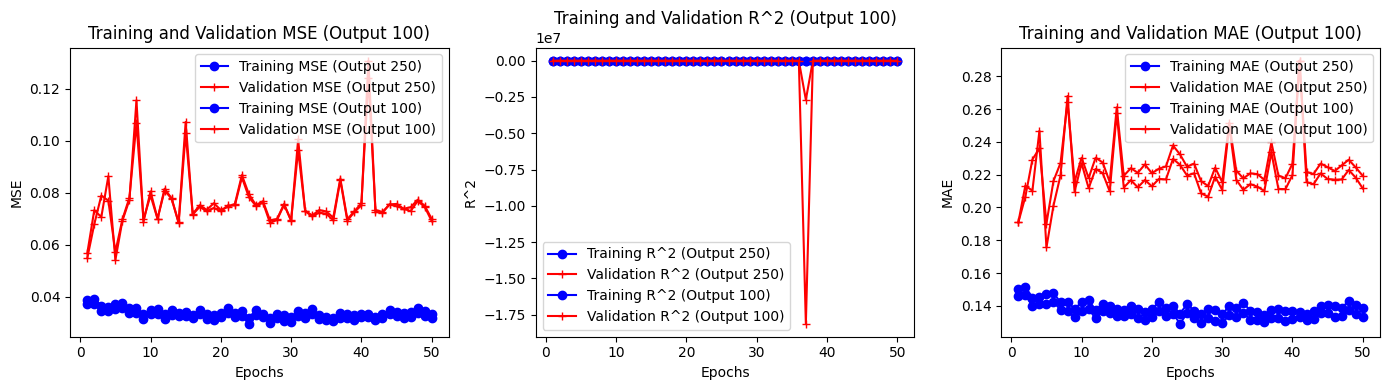

In [70]:
import matplotlib.pyplot as plt

# 定义一个函数来绘制训练历史曲线
def plot_history(metric, val_metric, title, ylabel):
    epochs = range(1, len(metric) + 1)
    plt.plot(epochs, metric, 'bo-', label='Training ' + title)
    plt.plot(epochs, val_metric, 'r+-', label='Validation ' + title)
    plt.title('Training and Validation ' + title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

# 获取历史数据
epochs = range(1, len(history.history['output_250_mse']) + 1)

# MSE
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plot_history(history.history['output_250_mse'], history.history['val_output_250_mse'], 'MSE (Output 250)', 'MSE')
plot_history(history.history['output_100_mse'], history.history['val_output_100_mse'], 'MSE (Output 100)', 'MSE')

# R^2
plt.subplot(1, 3, 2)
plot_history(history.history['output_250_r_squared'], history.history['val_output_250_r_squared'], 'R^2 (Output 250)', 'R^2')
plot_history(history.history['output_100_r_squared'], history.history['val_output_100_r_squared'], 'R^2 (Output 100)', 'R^2')

# MAE
plt.subplot(1, 3, 3)
plot_history(history.history['output_250_mae'], history.history['val_output_250_mae'], 'MAE (Output 250)', 'MAE')
plot_history(history.history['output_100_mae'], history.history['val_output_100_mae'], 'MAE (Output 100)', 'MAE')

plt.tight_layout()
plt.show()


In [ ]:
val_sequence.reset()

In [71]:
test_sequence =TrainSequence(TEST_IMAGES,BATCH_SIZE, patch_sizes, bands_count, STEPS, label_dirs)

In [ ]:
#test_sequence = ValSequence(TEST_IMAGES, BATCH_SIZE, patch_sizes, bands_count, ['LABEL_250_DIR', 'LABEL_100_DIR'])

In [72]:
results = model.evaluate(test_sequence, verbose=1)

print(f"\nTest loss: {results[0]:.4f}")
print(f"Output 250 Loss: {results[1]:.4f}")
print(f"Output 100 Loss: {results[2]:.4f}")
print(f"Output 250 MSE: {results[3]:.4f}")
print(f"Output 250 R^2: {results[4]:.4f}")
print(f"Output 250 MAE: {results[5]:.4f}")
print(f"Output 100 MSE: {results[6]:.4f}")
print(f"Output 100 R^2: {results[7]:.4f}")
print(f"Output 100 MAE: {results[8]:.4f}")


500/500 [==============================] - 147s 293ms/step - loss: 0.0498 - output_250_loss: 0.0469 - output_100_loss: 0.0518 - output_250_mse: 0.0469 - output_250_r_squared: -10.2014 - output_250_mae: 0.1645 - output_100_mse: 0.0518 - output_100_r_squared: -6.9518 - output_100_mae: 0.1764

Test loss: 0.0498
Output 250 Loss: 0.0469
Output 100 Loss: 0.0518
Output 250 MSE: 0.0469
Output 250 R^2: -10.2014
Output 250 MAE: 0.1645
Output 100 MSE: 0.0518
Output 100 R^2: -6.9518
Output 100 MAE: 0.1764


In [ ]:
# save the weight of the trained network
model.save_weights("/home/jovyan/private/thesis_data/code/final_code/weight/0403_3_2e-3_25.h5")

In [ ]:
def apply_biomass_estimation(image, regression_model, patch_size, step=！！！):
    original_height, original_width, _ = image.shape
    padded, (pad_height, pad_width) = pad_image_to_patch_size(image, patch_size)
    height, width, _ = padded.shape
    
    predictions = np.zeros((height, width))  # 单通道预测值
    
    row = 0
    while row + patch_size <= height:
        row_patches = []

        col = 0 
        while col + patch_size <= width:
            patch = padded[row:row + patch_size, col:col + patch_size, :]
            row_patches.append(patch)
            col += step

        batch = np.array(row_patches)
        row_predictions = regression_model.predict(batch, verbose=0)

        col, patch_idx = 0, 0
        while col + patch_size <= width:
            # 对于回归，我们可能直接取预测值而不是累加
            predictions[row:row + patch_size, col:col + patch_size] = \
                row_predictions[patch_idx].reshape(patch_size, patch_size)
            col += step
            patch_idx += 1

        row += step

    predictions = predictions[
        pad_height:pad_height + original_height,
        pad_width:pad_width + original_width
    ]
    
    return predictions


In [ ]:
SCENE_IDX = 0
image_path = os.path.join(IMAGE_DIR, VAL_IMAGES[SCENE_IDX])
label_path = os.path.join(LABEL_DIR, VAL_IMAGES[SCENE_IDX])

image = read_image(image_path, normalise=True)
label = map_classes(read_image(label_path))

prediction = apply_segmentation_with_fcn(image, model)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction")

plt.tight_layout()
plt.show()

In [ ]:
SCENE_IDX = 1
image_path = os.path.join(IMAGE_DIR, VAL_IMAGES[SCENE_IDX])
label_path = os.path.join(LABEL_DIR, VAL_IMAGES[SCENE_IDX])

image = read_image(image_path, normalise=True)
label = map_classes(read_image(label_path))

prediction = apply_segmentation_with_fcn(image, model)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction")

plt.tight_layout()
plt.show()